# EDA & preprocessing

In this notebook, we take a closer look at the data provided (EDA) and lay out several preprocessing steps for making the data more suitable for certain kinds of models.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%mkdir /content/gdrive/MyDrive/Electricity_Data
%cd /content/gdrive/MyDrive/Electricity_Data

Mounted at /content/gdrive
/content/gdrive/MyDrive/Electricity_Data


In [3]:
# Demonstration data used in this excercise is already preprocessed and split into
# training, validation, and test sets

# Use wget to download the data stored in csv format.
import itertools

# Define what files to download; download all of the preprocessed data
# Note that the data are already split into Train, Validation, and Test sets.
# The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

# Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
  file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  # the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")

'The kind of data to be downloaded:'

[{'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 15}]

--2021-11-08 16:29:05--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/X_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.74.120
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.74.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53997719 (51M) [text/csv]
Saving to: ‘X_train_window_size_5_time_encoding_True.csv’

X_train_window_size 100%[===================>]  51.50M  15.2MB/s    in 4.3s    

2021-11-08 16:29:10 (12.0 MB/s) - ‘X_train_window_size_5_time_encoding_True.csv’ saved [53997719/53997719]

--2021-11-08 16:29:10--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/y_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-sch

In [4]:
# load data for both window size 5
X_train_window_size_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
X_valid_window_size_5 = pd.read_csv('X_valid_window_size_5_time_encoding_True.csv')
X_test_window_size_5 = pd.read_csv('X_test_window_size_5_time_encoding_True.csv')
y_train_window_size_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')
y_valid_window_size_5 = pd.read_csv('y_valid_window_size_5_time_encoding_True.csv')
y_test_window_size_5 = pd.read_csv('y_test_window_size_5_time_encoding_True.csv')

# load data for both window size 15
X_train_window_size_15 = pd.read_csv('X_train_window_size_15_time_encoding_True.csv')
X_valid_window_size_15 = pd.read_csv('X_valid_window_size_15_time_encoding_True.csv')
X_test_window_size_15 = pd.read_csv('X_test_window_size_15_time_encoding_True.csv')
y_train_window_size_15 = pd.read_csv('y_train_window_size_15_time_encoding_True.csv')
y_valid_window_size_15 = pd.read_csv('y_valid_window_size_15_time_encoding_True.csv')
y_test_window_size_15 = pd.read_csv('y_test_window_size_15_time_encoding_True.csv')

## EDA

**What are we dealing with?**

The data at hand is about electricity contracts trades.

There are two different sets of data, looking at different numbers of timesteps (trading hours) in the past, either 5 or 15 steps (i.e., window size) for a lot of different contracts.

At this point, this is all you need to know. 

Using the following steps, we will go through the actual features and the datasets' structure in order to explore the data and get familiar with it.
- a) Data structure
- b) Candles
- c) Correlation matrix

### a) Data structure

When we look at the columns (see below), we can identify several features:
- **total_hours**: hours from the first trade we know for a given contract until delivery start of the same contract
- **dlvry_weekend**: whether the electricity is to be delivered on a weekend (binary)
- **dlvry_bank_holiday**: whether the electricity is to be delivered on a bank holiday (binary)
- **dlvry_day_sin** & **dlvry_day_cos**: sine/cosine-transformed day of delivery
- **dlvry_weekday_sin** & **dlvry_weekday_cos**: sine/cosine-transformed weekday of delivery
- **dlvry_hour_sin** & **dlvry_hour_cos**: sine/cosine-transformed hour of delivery
- **lasttrade_weekend**: whether most recent trading hour was on a weekend (binary)
- **lasttrade_bank_holiday**: whether most recent trading hour was on a holiday (binary)
- **lasttrade_day_sin** & **lasttrade_day_cos**: sine/cosine-transformed day of most recent trading hour
- **lasttrade_weekday_sin** & **lasttrade_weekday_cos**: sine/cosine-transformed weekday of most recent trading hour
- **lasttrade_hour_sin** & **lasttrade_hour_cos**: sine/cosine-transformed hour of most recent trading hour

All the aforementioned features, are the same for the both window sizes (5 and 15).

In [5]:
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

Okay, those features are quite intuitive, but what about all those integer-named columns?

They represent 6 additional features for each time step within for the specified window size. As they are a series of values obtained at successive times, these features can be seen as time series. More specifically, the values represent the differences in values between time steps, which is why we have ```window size - 1``` values for each time series feature. This is why the data set with window size 5 has 24 time series columns (```6 features * 4 time steps```) and the window size 15 data set has 84 (```6 features * 14 time steps```).

Using the overview below, we grasp the mapping of integer-named columns and their meaning more intuitively. 

 <img src="https://i.imgur.com/LuxS3XN.png">

 <img src="https://i.imgur.com/ncXBL73.png">

So, let's give meaningful names to the columns with integer column names, in line with the structure provided above.

In [6]:
# create function for changing the integer-based column names for window size 5
def rename_time_series_5(df):
    labels = ["open", "high", "low", "close", "volume", "minutes"]
    new_cols = list(df.columns[:17])
    for i in range(4, 0, -1):
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")

    df_original = df.copy()
    df.columns = new_cols

    return df

In [7]:
# create function for changing the integer-based column names for window size 15
def rename_time_series_15(df):
    labels = ["open", "high", "low", "close", "volume", "minutes"]
    new_cols = list(df.columns[:17])
    for i in range(14, 0, -1):
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")

    df_original = df.copy()
    df.columns = new_cols

    return df

In [8]:
# apply renaming functions to all X datasets
X_train_window_size_5 = rename_time_series_5(X_train_window_size_5)
X_valid_window_size_5 = rename_time_series_5(X_valid_window_size_5)
X_test_window_size_5 = rename_time_series_5(X_test_window_size_5)

# load data for both window size 15
X_train_window_size_15 = rename_time_series_15(X_train_window_size_15)
X_valid_window_size_15 = rename_time_series_15(X_valid_window_size_15)
X_test_window_size_15 = rename_time_series_15(X_test_window_size_15)

In [9]:
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

For example, open_3_2 is the difference from the open price in t-3 compared to the open price in t-2.

Now that we got an understaning of the columns, let's focus on the rows.

The underlying data-generating entities are different contracts. Multiple rows could, in theory, stem from the same contract, as its trading history can be split into multiple sliding windows.

We can use the total_hours as a proxy primary key for identifying the underlying contract for each row of the data.

In [10]:
# group by total_hours features
X_train_window_size_5_grouped = X_train_window_size_5.groupby("total_hours").size().reset_index()
X_train_window_size_5_grouped.rename(columns={0: "rowcount"}, inplace=True)

print(f"The mininum amount of rows attributed to a specific contract for window size 5 is: {X_train_window_size_5_grouped['rowcount'].min()}")
print(f"The maximum amount of rows attributed to a specific contract for window size 5 is: {X_train_window_size_5_grouped['rowcount'].max()}")
print(f"The mean amount of rows attributed to a specific contract for window size 5 is: {round(X_train_window_size_5_grouped['rowcount'].mean())}")

The mininum amount of rows attributed to a specific contract for window size 5 is: 1
The maximum amount of rows attributed to a specific contract for window size 5 is: 44
The mean amount of rows attributed to a specific contract for window size 5 is: 12


In [11]:
# group by total_hours features
X_train_window_size_15_grouped = X_train_window_size_15.groupby("total_hours").size().reset_index()
X_train_window_size_15_grouped.rename(columns={0: "rowcount"}, inplace=True)

print(f"The mininum amount of rows attributed to a specific contract for window size 15 is: {X_train_window_size_15_grouped['rowcount'].min()}")
print(f"The maximum amount of rows attributed to a specific contract for window size 15 is: {X_train_window_size_15_grouped['rowcount'].max()}")
print(f"The mean amount of rows attributed to a specific contract for window size 15 is: {round(X_train_window_size_15_grouped['rowcount'].mean())}")

The mininum amount of rows attributed to a specific contract for window size 15 is: 1
The maximum amount of rows attributed to a specific contract for window size 15 is: 24
The mean amount of rows attributed to a specific contract for window size 15 is: 7


This also highlights the difficulty that the data is not a continuous time series, but rather is composed of many time series that can occur in parallel.

### b) Candles

Another way of looking at the data and spur an understanign is to use the visualization as candles.

In [12]:
# create helper function to plot candles
def plot_subplots(dataframe: pd.DataFrame, title: str):
    """
    Draws one subplot for each of the columns in the DataFrame.
    """
    
    fig, axes = plt.subplots(nrows=len(dataframe.columns), figsize=(20,20))
    labels = list(dataframe.columns)

    for idx, row in enumerate(axes):
        y = dataframe.iloc[:, idx]
        row.plot(y, label=y.name)
        row.set_ylabel(labels[idx])

    fig.set_facecolor("grey")
    fig.suptitle(title, size=15, y=0.9)
    plt.show()

In [13]:
# create helper function to plot candles
def plot_subplots_wrapper(
    dataframe: pd.DataFrame,
    title: str,
    labels: list = ["open", "high", "low", "close", "volume"]
    ):
    """
    Calls the 'plot_subplots' function for each label provided in labels and selects columns that start with the label.
    """

    #df = dataframe.copy()
    for label in labels:
        print(f"Plots for {label}:")
        title = title + f" {label}"
        plot_subplots(dataframe.loc[:,dataframe.columns.str.startswith(label)], title)

Let's look at the differenced feature open, high, low, close and volume in the training data for window size 5.

Plots for open:


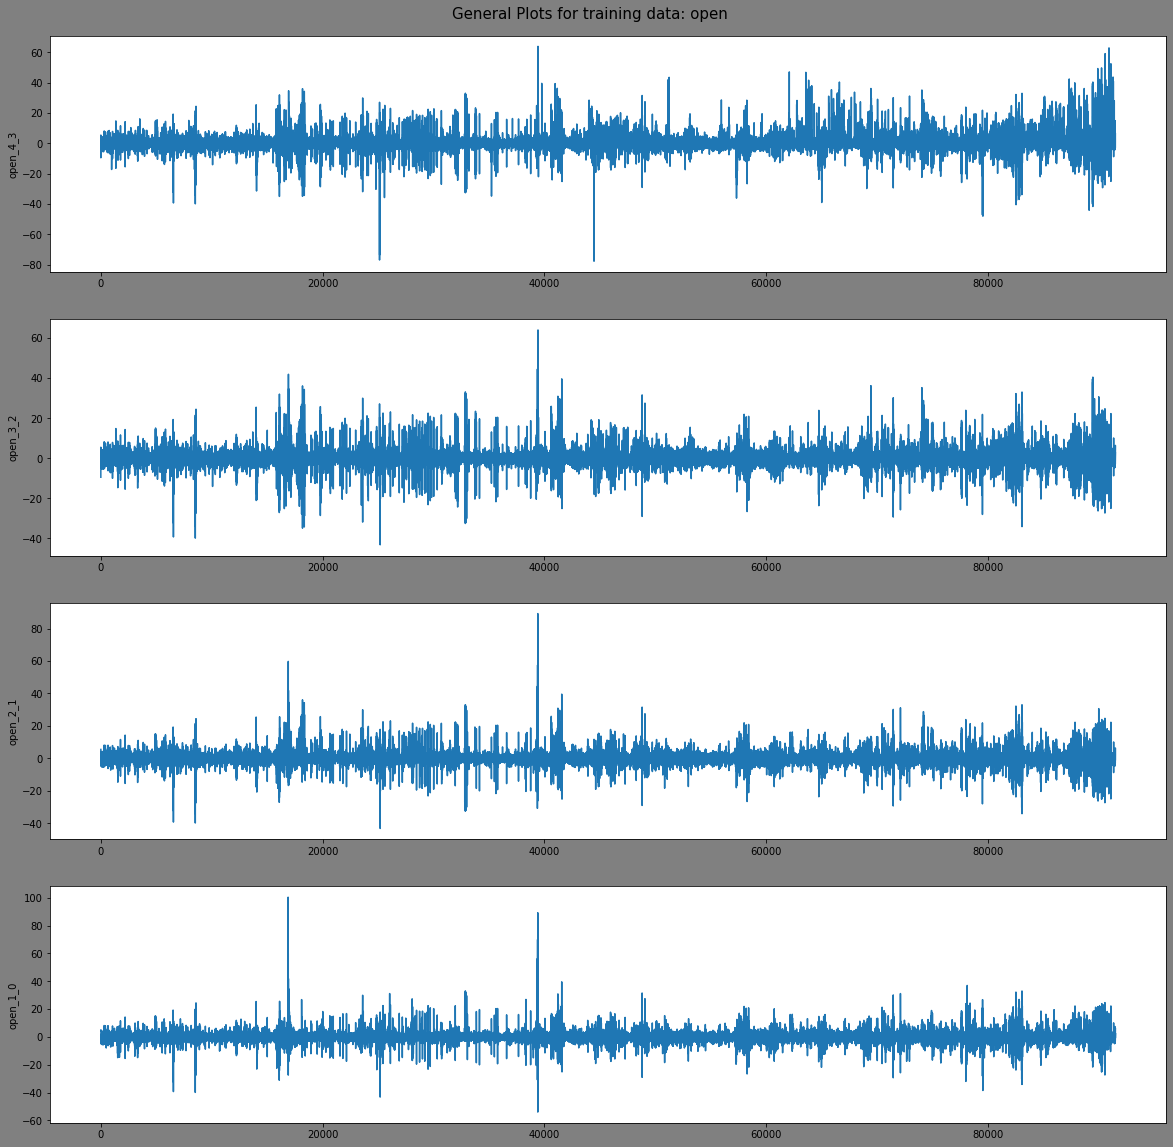

Plots for high:


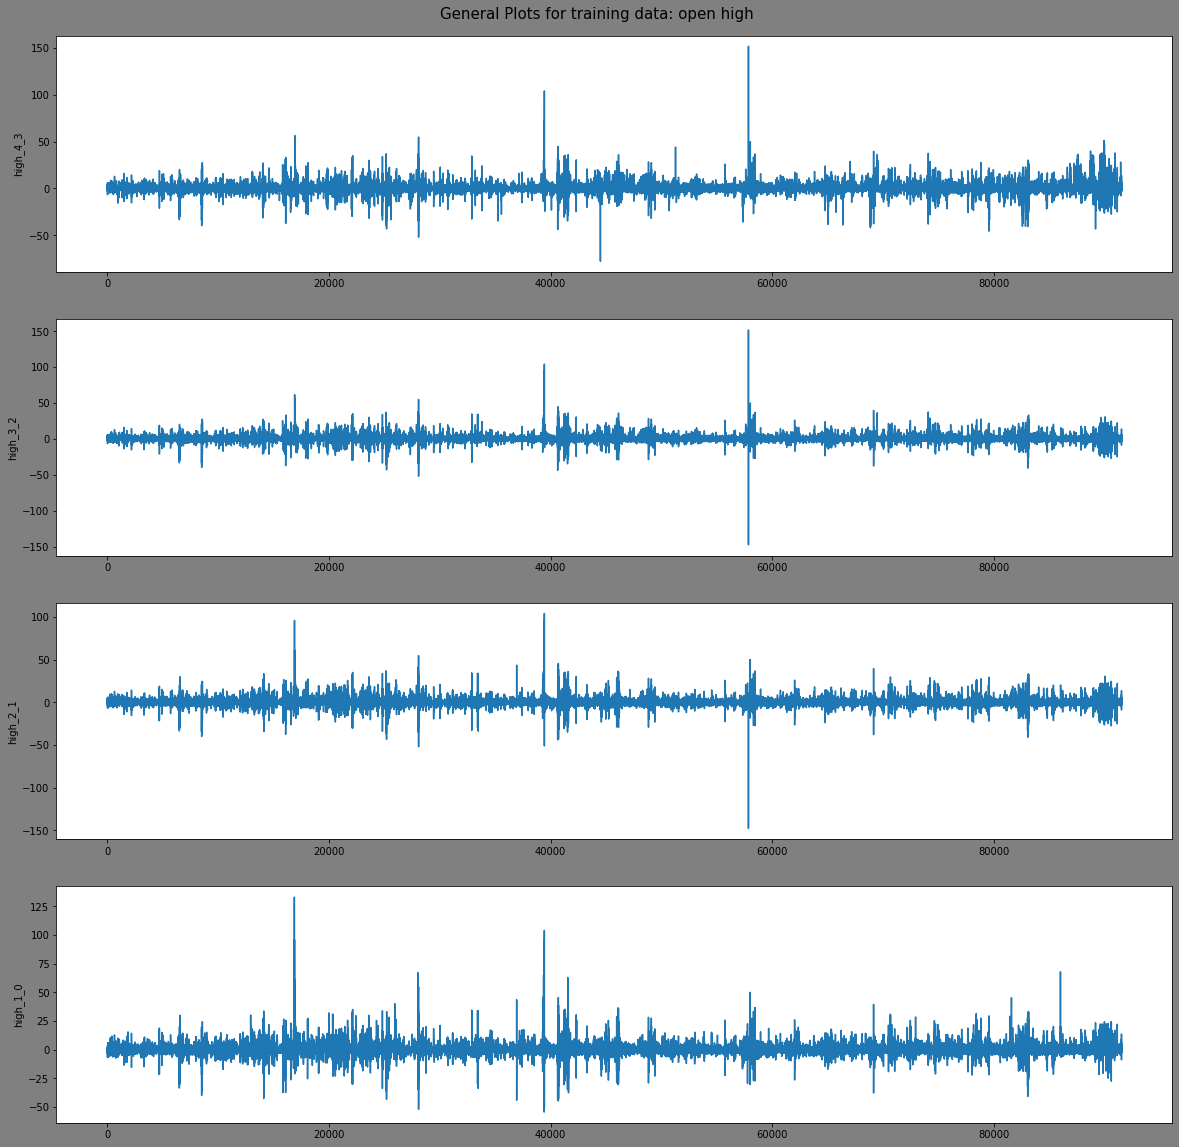

Plots for low:


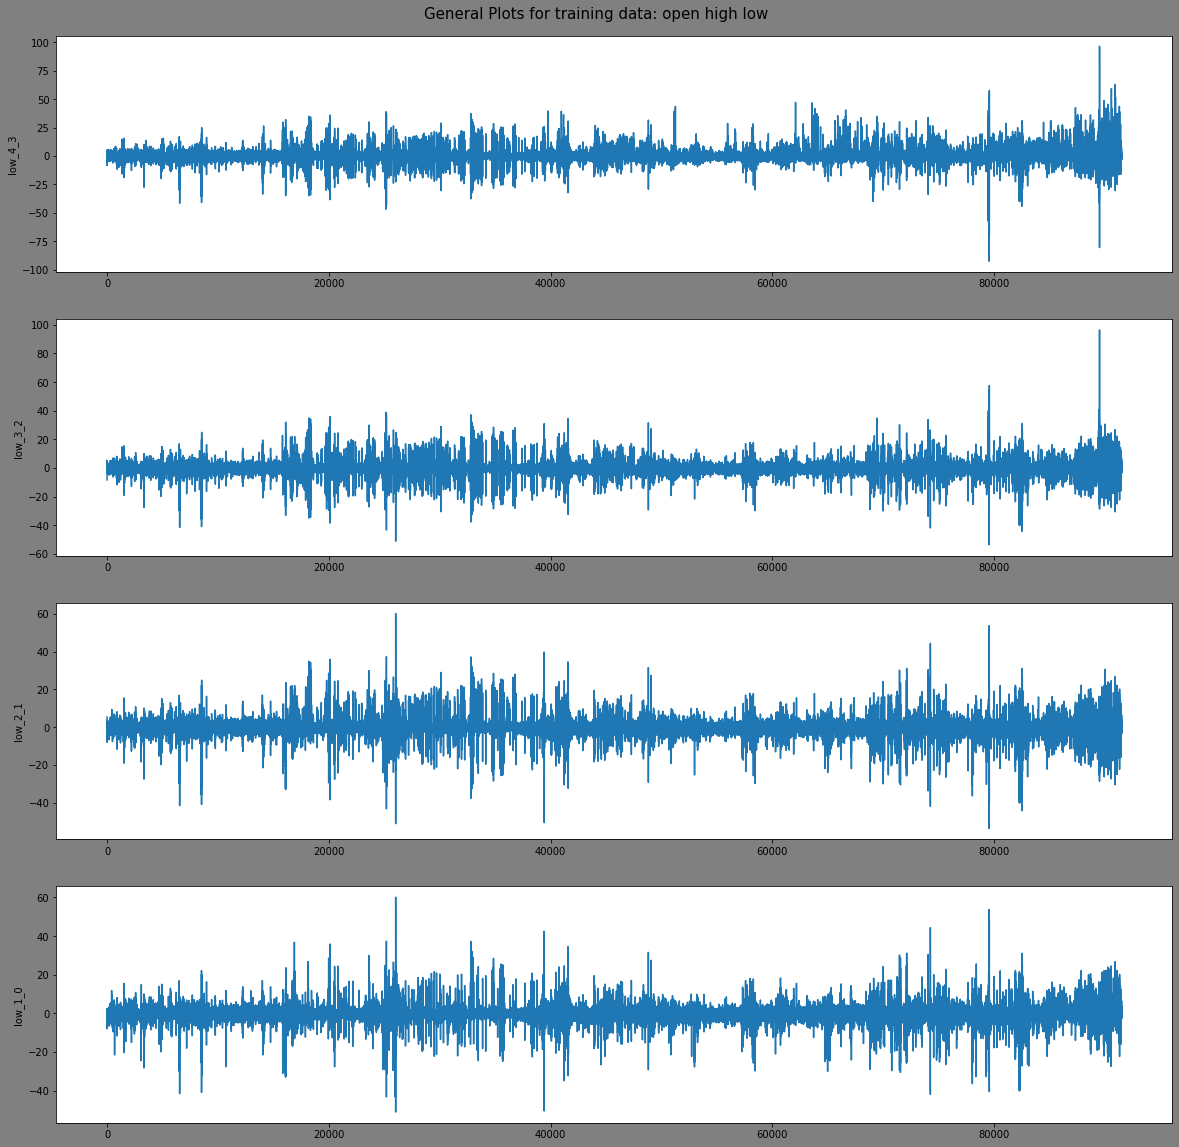

Plots for close:


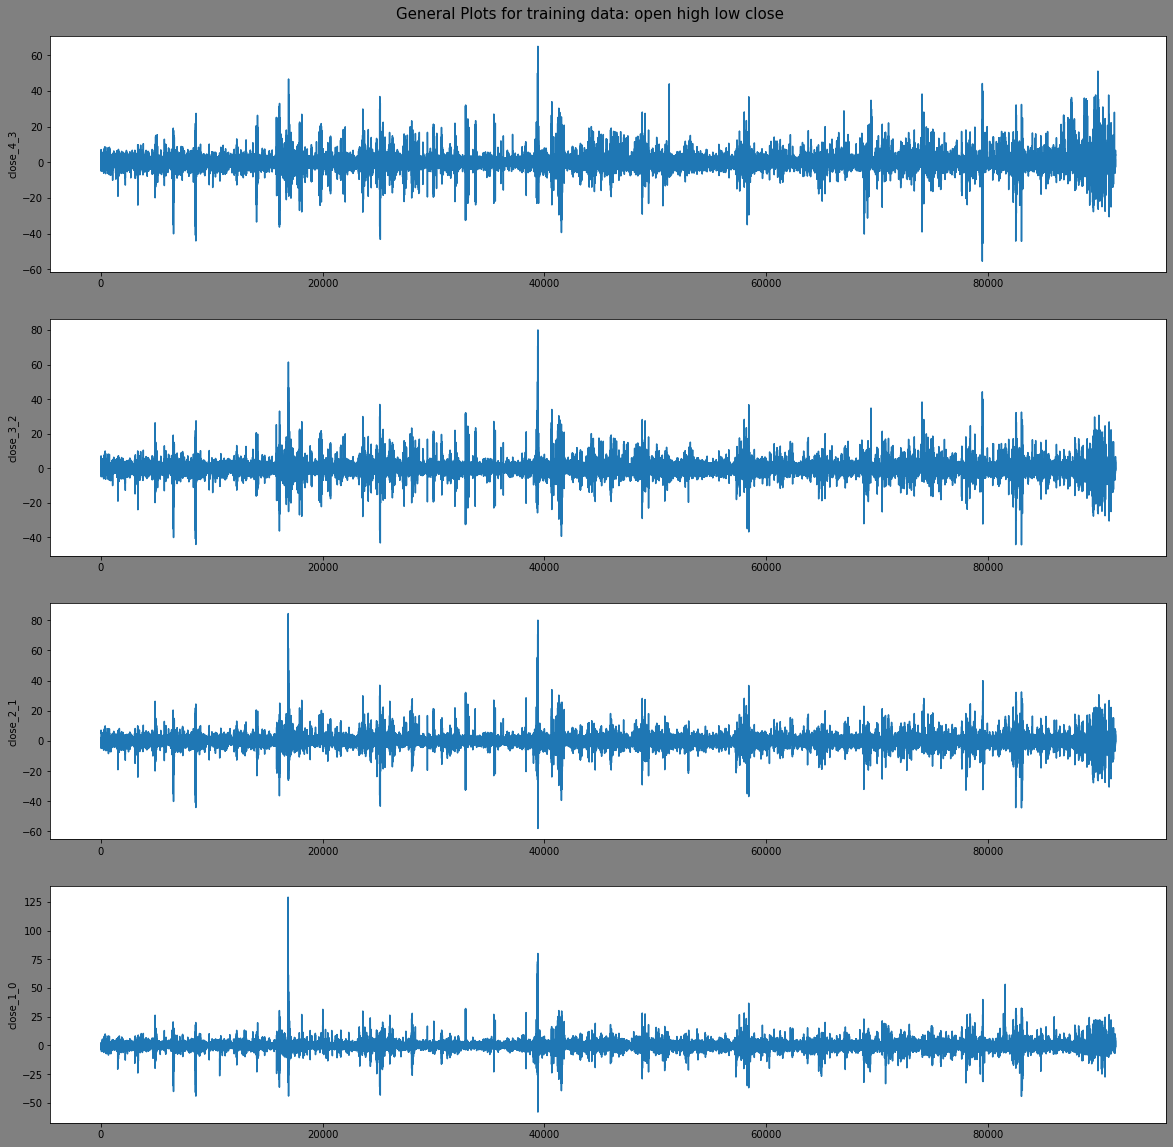

Plots for volume:


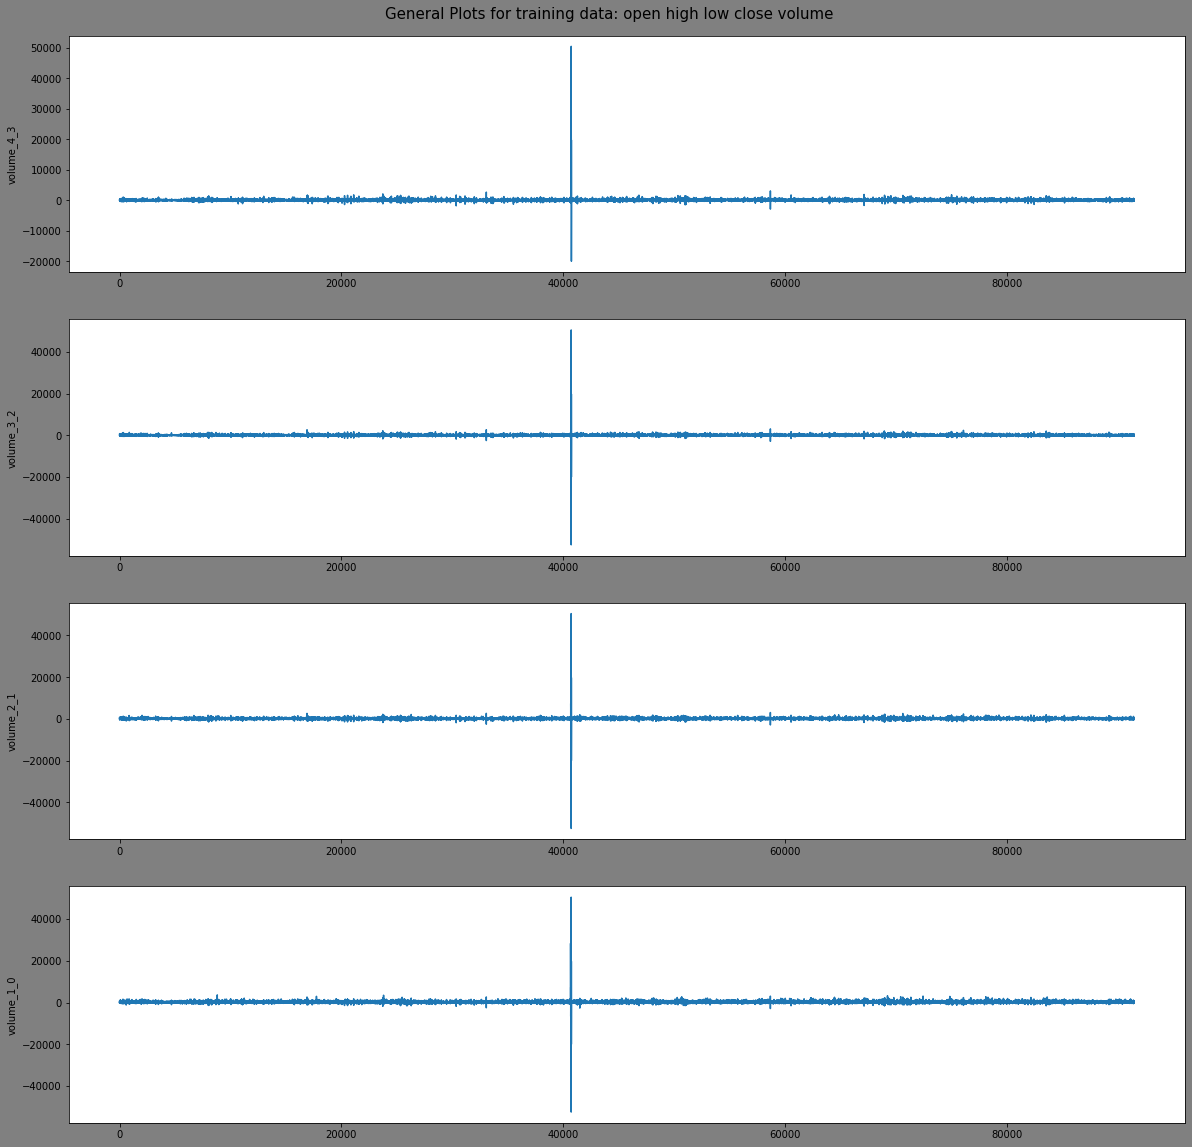

In [14]:
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for training data:"
plot_subplots_wrapper(df_to_plot, title)

The fact that the resulting plots seem to be centered around 0 (similar to the representations of sound wave recordings) already suggests that positive differences are followed by negative differences and vice versa. Please keep in mind that this is just a crude concatenation of the open, high, low, close and volume values, across all the different contracts included in the data.

### c) Correlation matrix

Finally, we can check whether there are significant linear relationships between the features using the correlation matrix. Linear relationships can easily be picked up by baseline and advanced models.

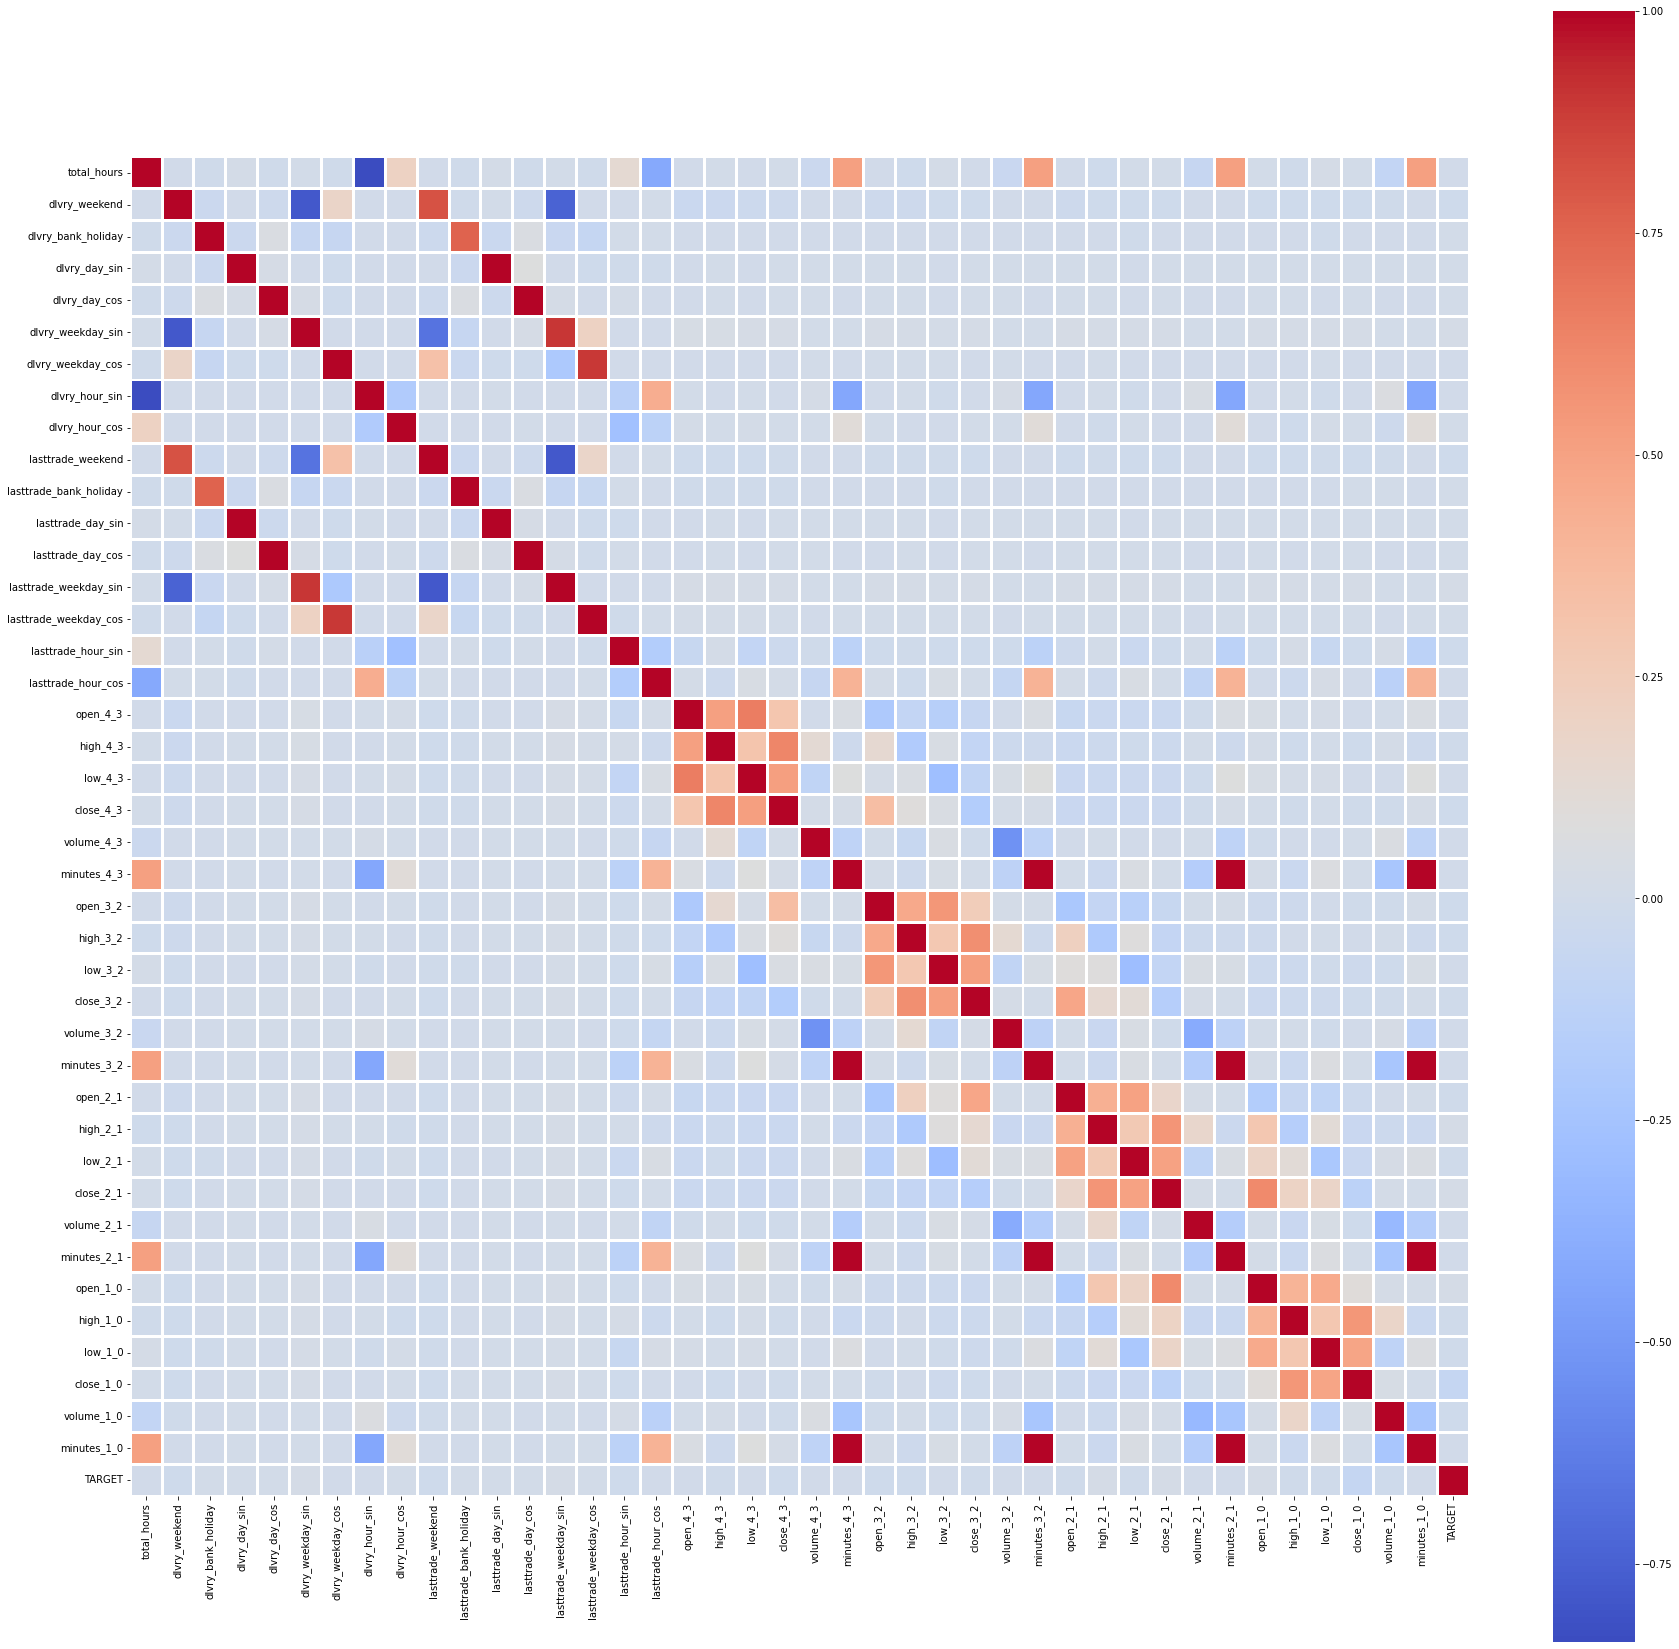

In [15]:
plt.figure(figsize=(30,30))
full_train_window_size_5 = X_train_window_size_5.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

The pattern seen for window size 5 continues for the additional time series features for the window size 15 data set.

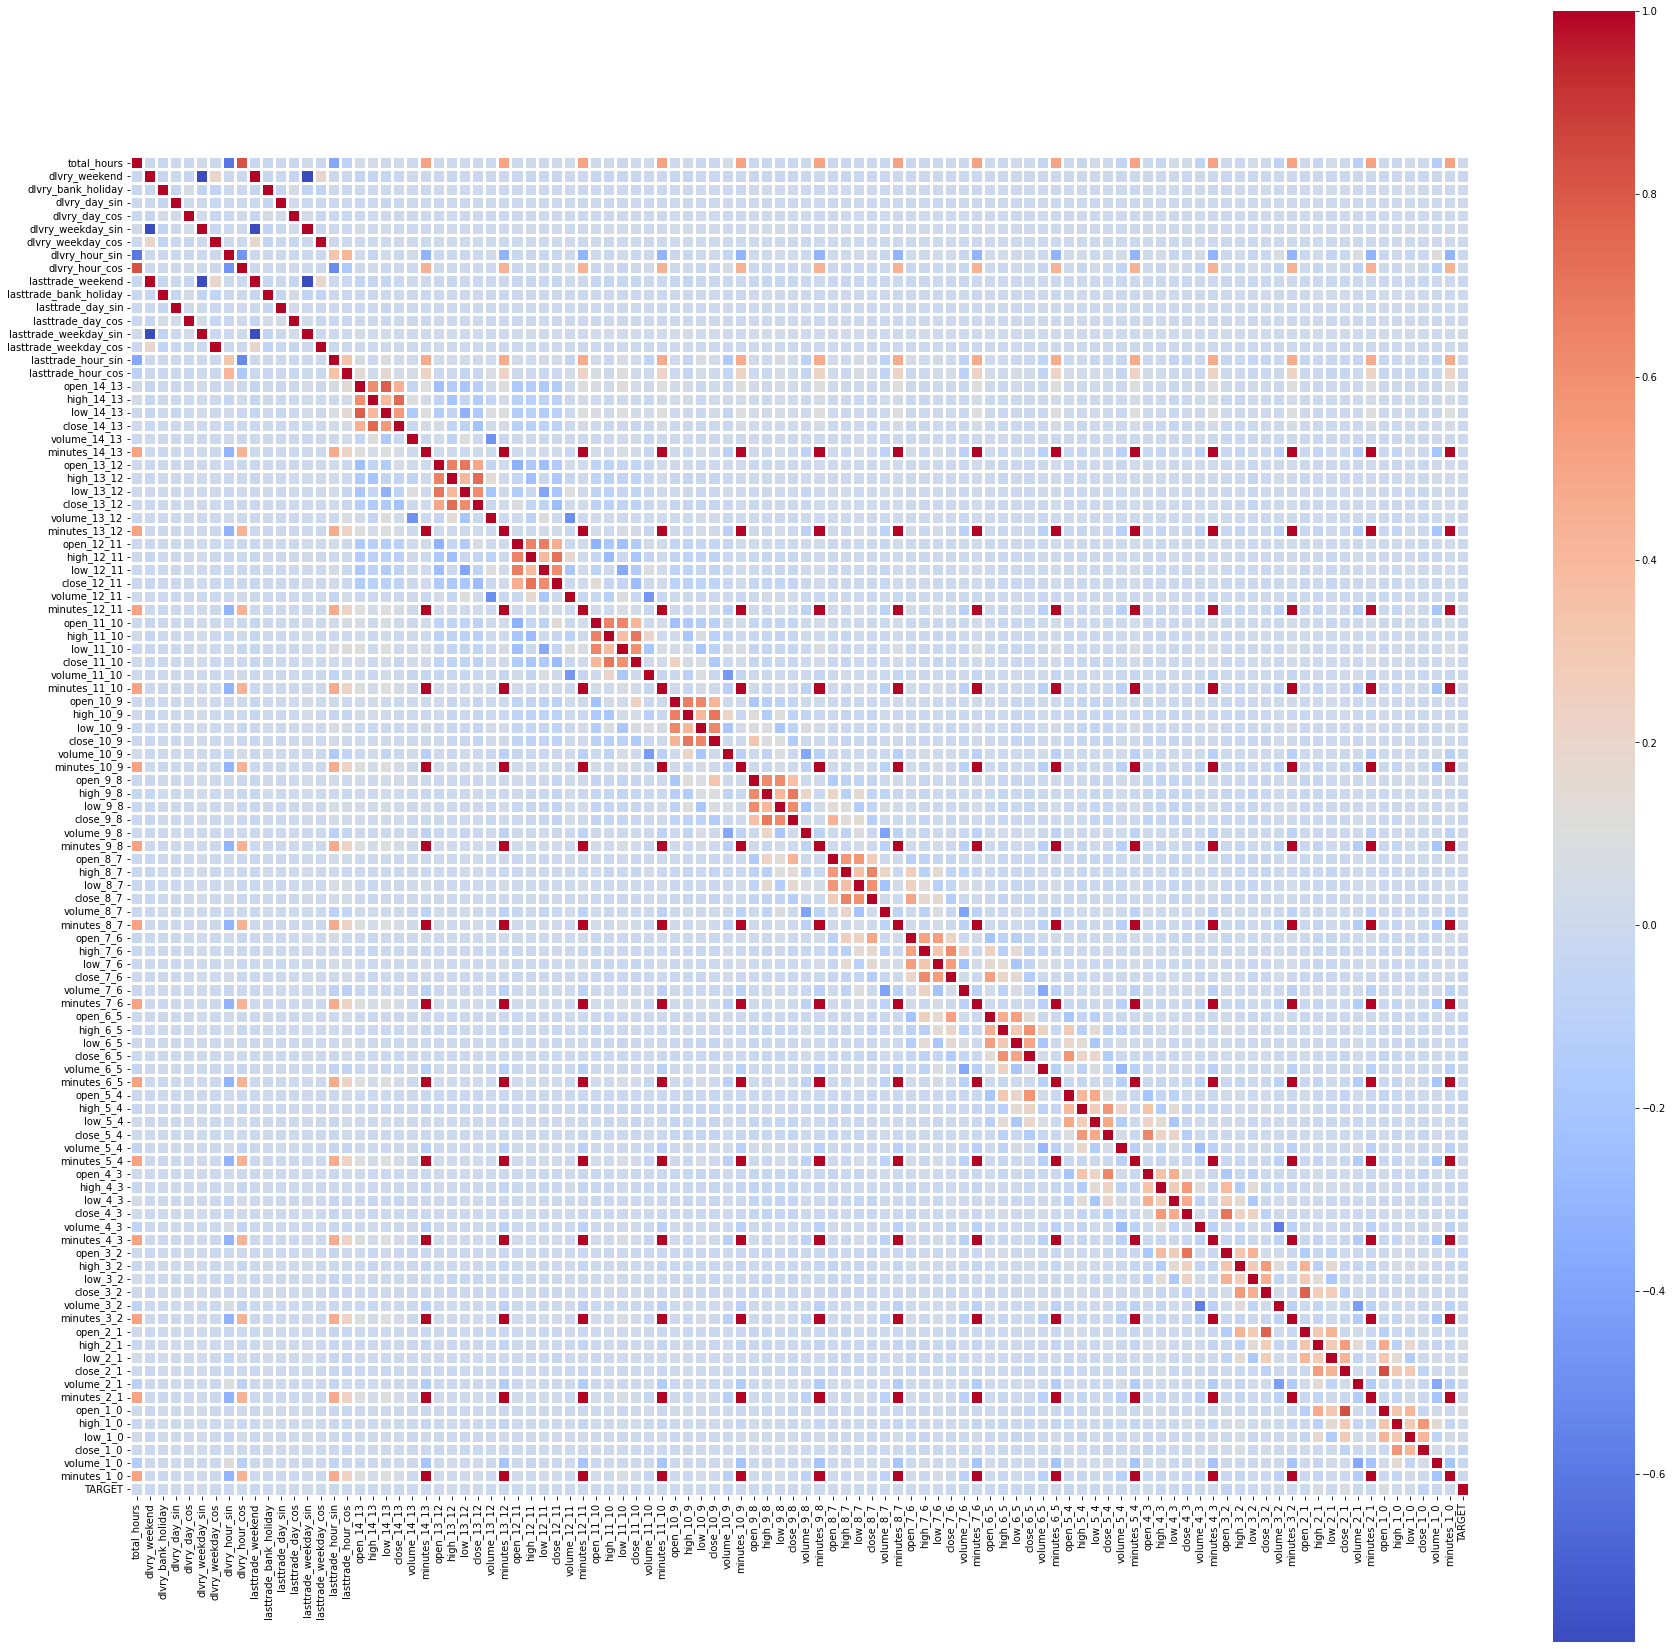

In [16]:
plt.figure(figsize=(30,30))
full_train_window_size_15 = X_train_window_size_15.copy()
full_train_window_size_15["TARGET"] = y_train_window_size_15["y"]
sns.heatmap(full_train_window_size_15.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

### Takeaways from correlation matrix for windows size 5 and 15:
- The target variable is not significantly correlated (linear) with any of the predictors 
- Most of the features are uncorrelated
- There are correlation patterns between the same features at different time steps and between the open, high, low and close prices differences within a specific time step


## Preprocessing

Although the data already came in a preprocessed format, there are several preprocessing measures to be taken, given the reasons listed below.
- a) **Retransforming sine/cosine-transformed cyclical features** in order to provide tree-based models (splitting on one column per split) with suitable data. Since the sine/cosine transformation creates separate sine and cosine columns per cyclical feature, tree-based approaches may split on the cosine column only, which disregards the corresponding sine column for representing the actual value.
- b) **Reshaping the data from 2D to 3D** in order to make it compatible with RNNs while keeping the time series structure intact.
- c) **Applying normalization** in order to align feature scales and prevent scale-sensitive models (e.g., SVM) from taking into account differently scaled features with different weightage.

These 3 preprocessing steps will result in different data sets that are to be used for the training of different models (see other notebeooks).

### a) Retransforming sine/cosine-transformed cyclical features

Tree-based approaches split nodes into sub-nodes on the basis of one feature at the time.

As we saw above, several features (i.e., dlvry_day, dlvry_weekday, dlvry_hour, lasttrade_day, lasttrade_weekday, lasttrade_hour) are sine/cosine-encoded, which means that they have a sine value and cosine value in separate columns for each feature respectively.

This is why, in the following, we will try to reproduce the mapping from sine/cosine values to original categorial values, assigning ordinal (e.g., Monday = 0, Tuesday = 1, ...) values. This approach, however, will erase the sine/cosine encoding's advantage of keeping the same distance between subsequent days. This is why the resulting data shall only be used for tree-based approaches.

As one cannot simply solve the underlying sine/cosine transformation formula to yield the original value (sine and cosine functions have many x-values for the same y-value), we have to reproduce the transformation in order to get the original values.

#### _weekday features

When we look at the values for the dlvry_weekday, we can see that there are 7 unique values, likely to correspond to the days of the week.

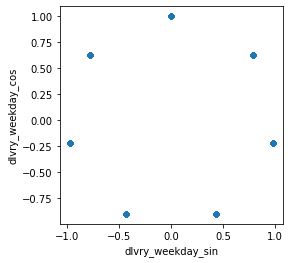

In [17]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_weekday_sin','dlvry_weekday_cos').set_aspect('equal')

In [18]:
# look at unique values
X_train_window_size_5.groupby(['dlvry_weekday_sin', 'dlvry_weekday_cos']).size().reset_index().rename(columns={0:'count'})

,dlvry_weekday_sin,dlvry_weekday_cos,count
0,-0.974928,-0.222521,12722
1,-0.781831,0.623490,12738
2,-0.433884,-0.900969,13163
3,0.000000,1.000000,12923
4,0.433884,-0.900969,13283
5,0.781831,0.623490,13156
6,0.974928,-0.222521,13527


With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for days of the week.

In [19]:
# from observation above
days_in_a_week = 7

mapping_day_of_week = {}

# apply cosine and sine transformaiton for every day of the week
for i in range(0, days_in_a_week):
    mapping_day_of_week[(round(np.sin(2*np.pi*i/days_in_a_week), 5), round(np.cos(2*np.pi*i/days_in_a_week), 5))] = i

In [20]:
# create function to convert sine- and cosine-transformed values back
def convert_weekday(sin, cos):
    """Return original value from sine- and cosine-transformed values

    Arguments:
    sin -- sine-transformed value
    cos -- cosine-transformed value"""
    weekday = mapping_day_of_week[(round(sin, 5), round(cos, 5))]
    return weekday

#### _hour features

When we look at the values for the dlvry_hour, we can see that there are most likely 24 possible values (points are distributed like a 24h clock, corresponding to the hours of the day.

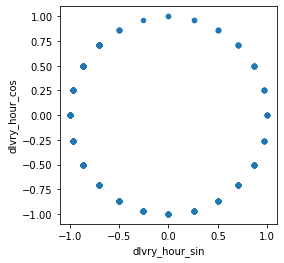

In [21]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_hour_sin','dlvry_hour_cos').set_aspect('equal')

Again, we can reproduce a mapping as done before.

In [22]:
hours_in_a_day = 24

mapping_hour_of_day = {}

# apply cosine and sine transformaiton for every hour of the day
for i in range(0, hours_in_a_day):
    mapping_hour_of_day[(round(np.sin(2*np.pi*i/hours_in_a_day), 5), round(np.cos(2*np.pi*i/hours_in_a_day), 5))] = i  

In [23]:
# create function to convert sine- and cosine-transformed values back
def convert_hour(sin, cos):
    hour = mapping_hour_of_day[(round(sin, 5), round(cos, 5))]
    return hour

#### _day features

When we look at the values for the dlvry_day, we can see that there is no obvious pattern like we observed for the _hour and _weekday features.

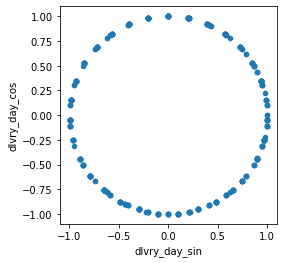

In [24]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_day_sin','dlvry_day_cos').set_aspect('equal')

In [25]:
# look at unique values
year_days = X_train_window_size_5.groupby(['dlvry_day_sin','dlvry_day_cos']).size().reset_index().rename(columns={0:'count'})
year_days = year_days[['dlvry_day_sin','dlvry_day_cos']].round(5)

Intuitively, we might assume that the transformation is based on 365 days in a year, but creating the respective mapping does not yield matches (see below), so we couldn't reproduce the sine and cosine features for the _day features.

In [26]:
days_in_a_year = 365

mapping_day = {}

for i in range(0, days_in_a_year):
    mapping_day[(round(np.sin(2*np.pi*i/days_in_a_year), 5), round(np.cos(2*np.pi*i/days_in_a_year), 5))] = i

# check whether there is a match with randomly picked values from the unique values above
try: 
    mapping_day[(0.98847, 0.15143)]
except KeyError:
    print("There is no match")

There is no match


Let's create the tree-friendly data.

In [27]:
def tree_transform(df, drop_day=True):
    """Return tree-friendly data with cos and sin features transformed back to original values

    Arguments:
    df -- dataset
    drop_day -- _day features cannot be transformed back, can be dropped or kept"""
    # create new columns for original values
    data = df.copy()
    data["dlvry_weekday"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
    data["lasttrade_weekday"] = data.apply(lambda x: convert_weekday(x['lasttrade_weekday_sin'], x['lasttrade_weekday_cos']), axis=1)
    data["dlvry_hour"] = data.apply(lambda x: convert_hour(x['dlvry_hour_sin'], x['dlvry_hour_cos']), axis=1)
    data[["lasttrade_hour"]] = data.apply(lambda x: convert_hour(x['lasttrade_hour_sin'], x['lasttrade_hour_cos']), axis=1)

    # drop redundant sine and cosine features
    data = data.drop(['dlvry_weekday_sin', 'dlvry_weekday_cos', 'lasttrade_weekday_sin', 
                      'lasttrade_weekday_cos', 'dlvry_hour_sin', 'dlvry_hour_cos', 
                      'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    # drop _day features as we couldn't transform them back
    if drop_day:
        data = data.drop(['dlvry_day_cos', 'dlvry_day_sin', 'lasttrade_day_sin', 'lasttrade_day_cos'], axis=1)

    return data

In [28]:
# create tree-friendly datasets
X_train_window_size_5_tree = tree_transform(X_train_window_size_5)
X_valid_window_size_5_tree = tree_transform(X_valid_window_size_5)
X_test_window_size_5_tree = tree_transform(X_test_window_size_5)
X_train_window_size_15_tree = tree_transform(X_train_window_size_15)
X_valid_window_size_15_tree = tree_transform(X_valid_window_size_15)
X_test_window_size_15_tree = tree_transform(X_test_window_size_15)


### b) Reshaping the data from 2D to 3D

RNNs require inout to be 3D with the second dimension being the time steps and the third dimension being the number of features.

In the following, we will reshape all of the features as well as only the open, high, low, close and volume features as 3D arrays.

The stacking-of-2D-tables approach can be shown with the image below.

 <img src="https://i.stack.imgur.com/vK5im.png"> 

In [29]:
def unflatten_ohlcv(data):
    """Return 3D data for open, high, low, close and volume (ohlcv) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- predictor data after renaming and normalization
    """

    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    minute_col = [col for col in X.columns if 'minutes' in col]
    X = X.drop(minute_col, axis = 1)

    # separate data per feature
    open_col = [col for col in X.columns if 'open' in col]
    X_open = X[open_col]
    high_col = [col for col in X.columns if 'high' in col]
    X_high = X[high_col]
    low_col = [col for col in X.columns if 'low' in col]
    X_low = X[low_col]
    close_col = [col for col in X.columns if 'close' in col]
    X_close = X[close_col]
    vol_col = [col for col in X.columns if 'volume' in col]
    X_vol = X[vol_col]

    # stack data
    X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

    return X

In [30]:
# transform window size 5 data
X_train_unflatten_5_ohlcv = unflatten_ohlcv(X_train_window_size_5)
X_valid_unflatten_5_ohlcv = unflatten_ohlcv(X_valid_window_size_5)
X_test_unflatten_5_ohlcv = unflatten_ohlcv(X_test_window_size_5)
print("Check dimensions. Second dimension should be 4.")
np.shape(X_train_unflatten_5_ohlcv), np.shape(X_valid_unflatten_5_ohlcv), np.shape(X_test_unflatten_5_ohlcv)

Check dimensions. Second dimension should be 4.


((91512, 4, 5), (4817, 4, 5), (10704, 4, 5))

In [31]:
# transform window size 15 data
X_train_unflatten_15_ohlcv = unflatten_ohlcv(X_train_window_size_15)
X_valid_unflatten_15_ohlcv = unflatten_ohlcv(X_valid_window_size_15)
X_test_unflatten_15_ohlcv = unflatten_ohlcv(X_test_window_size_15)
print("Check dimensions. Second dimension should be 14.")
np.shape(X_train_unflatten_15_ohlcv), np.shape(X_valid_unflatten_15_ohlcv), np.shape(X_test_unflatten_15_ohlcv)

Check dimensions. Second dimension should be 14.


((29888, 14, 5), (1574, 14, 5), (3496, 14, 5))

For features other than open, high, low, close and volume there does not exist a (different) value for each time step, so we copied the respective features to be in line with the dimensionality requirements (4 or 14 times depending on the data set).

In [32]:
def unflatten_all(data, window_size):
    """Return 3D data for all features (except minutes left) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- predictor data after renaming and normalization
    window_size -- either 5 or 15
    """

    timesteps = window_size - 1

    X_no_ts = []

    # copy every non time series feature to get right shape
    for feature in data.iloc[:,:17].columns:
      X_feat = pd.concat([data[feature]]*timesteps, axis=1)
      X_no_ts.append(X_feat)
    
    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    minute_col = [col for col in X.columns if 'minutes' in col]
    X = X.drop(minute_col, axis = 1)

    # separate data per feature
    open_col = [col for col in X.columns if 'open' in col]
    X_open = X[open_col]
    high_col = [col for col in X.columns if 'high' in col]
    X_high = X[high_col]
    low_col = [col for col in X.columns if 'low' in col]
    X_low = X[low_col]
    close_col = [col for col in X.columns if 'close' in col]
    X_close = X[close_col]
    vol_col = [col for col in X.columns if 'volume' in col]
    X_vol = X[vol_col]

    # all seperate data
    X_all_feat = [X_open, X_high, X_low, X_close, X_vol]
    X_all_feat.extend(X_no_ts)

    # stack data
    X = np.stack(X_all_feat, axis = 2)

    return X

In [33]:
# transform window size 5 data
X_train_unflatten_all_5 = unflatten_all(X_train_window_size_5, 5)
X_valid_unflatten_all_5 = unflatten_all(X_valid_window_size_5, 5)
X_test_unflatten_all_5 = unflatten_all(X_test_window_size_5, 5)
print("Check dimensions. Second dimension should be 4.")
np.shape(X_train_unflatten_all_5), np.shape(X_valid_unflatten_all_5), np.shape(X_test_unflatten_all_5)

Check dimensions. Second dimension should be 4.


((91512, 4, 22), (4817, 4, 22), (10704, 4, 22))

In [34]:
# transform window size 15 data
X_train_unflatten_all_15 = unflatten_all(X_train_window_size_15, 15)
X_valid_unflatten_all_15 = unflatten_all(X_valid_window_size_15, 15)
X_test_unflatten_all_15 = unflatten_all(X_test_window_size_15, 15)
print("Check dimensions. Second dimension should be 14.")
np.shape(X_train_unflatten_all_15), np.shape(X_valid_unflatten_all_15), np.shape(X_test_unflatten_all_15)

Check dimensions. Second dimension should be 14.


((29888, 14, 22), (1574, 14, 22), (3496, 14, 22))

### c) Applying normalization

Large differences in the scales of different features (think for example height in meters vs. number of blood cells) can cause problems for many models which might assign higher wieghting to large numbers.
As the underlying unit should be irrelevant, we can align the features' scale without distorting the differences between values within the ranges, thereby not losing information.

Please note, that scale-robust models such as tree-based approaches should not perform worse when the input data is normalized due to the aforementioned characteristis of not changing the relative values within the range.

In the following we will apply the MinMaxScaler to the time series features of the data sets.

In [35]:
scaler5 = MinMaxScaler()
X_train_window_size_5[X_train_window_size_5.columns[17:]] = scaler5.fit_transform(X_train_window_size_5[X_train_window_size_5.columns[17:]])
X_valid_window_size_5[X_valid_window_size_5.columns[17:]] = scaler5.transform(X_valid_window_size_5[X_valid_window_size_5.columns[17:]])
X_test_window_size_5[X_test_window_size_5.columns[17:]] = scaler5.transform(X_test_window_size_5[X_test_window_size_5.columns[17:]])

scaler15 = MinMaxScaler()
X_train_window_size_15[X_train_window_size_15.columns[17:]] = scaler15.fit_transform(X_train_window_size_15[X_train_window_size_15.columns[17:]])
X_valid_window_size_15[X_valid_window_size_15.columns[17:]] = scaler15.transform(X_valid_window_size_15[X_valid_window_size_15.columns[17:]])
X_test_window_size_15[X_test_window_size_15.columns[17:]] = scaler15.transform(X_test_window_size_15[X_test_window_size_15.columns[17:]])

*Save all datasets*

In [37]:
# tree-friendly data
# read back using:
#      <name> = pd.read_csv("<name>"", index_col=0)
X_train_window_size_5_tree.to_csv("X_train_window_size_5_tree.csv")
X_valid_window_size_5_tree.to_csv("X_valid_window_size_5_tree.csv")
X_test_window_size_5_tree.to_csv("X_test_window_size_5_tree.csv")
X_train_window_size_15_tree.to_csv("X_train_window_size_15_tree.csv")
X_valid_window_size_15_tree.to_csv("X_valid_window_size_15_tree.csv")
X_test_window_size_15_tree.to_csv("X_test_window_size_15_tree.csv")

# normalized data
# read back using:
#      <name> = pd.read_csv("<name>"", index_col=0)
X_train_window_size_5.to_csv("X_train_window_size_5.csv")
X_valid_window_size_5.to_csv("X_valid_window_size_5.csv")
X_test_window_size_5.to_csv("X_test_window_size_5.csv")
X_train_window_size_15.to_csv("X_train_window_size_15.csv")
X_valid_window_size_15.to_csv("X_valid_window_size_15.csv")
X_test_window_size_15.to_csv("X_test_window_size_15.csv")


y_train_window_size_5.to_csv('y_train_window_size_5.csv')
y_valid_window_size_5.to_csv('y_valid_window_size_5.csv')
y_test_window_size_5.to_csv('y_test_window_size_5.csv')
y_train_window_size_15.to_csv('y_train_window_size_15.csv')
y_valid_window_size_15.to_csv('y_valid_window_size_15.csv')
y_test_window_size_15.to_csv('y_test_window_size_15.csv')

# 3D data has to be saved using pickle as it's 3-dimensional
# read back using:
#     pkl_file = open("<name>", 'rb')
#     <name> = pickle.load(pkl_file)
datasets_3D = {"X_train_unflatten_5_ohlcv": X_train_unflatten_5_ohlcv,
               "X_valid_unflatten_5_ohlcv": X_valid_unflatten_5_ohlcv,
               "X_test_unflatten_5_ohlcv": X_test_unflatten_5_ohlcv, 
               "X_train_unflatten_15_ohlcv": X_train_unflatten_15_ohlcv,
               "X_valid_unflatten_15_ohlcv": X_valid_unflatten_15_ohlcv,
               "X_test_unflatten_15_ohlcv": X_test_unflatten_15_ohlcv, 
               "X_train_unflatten_all_5": X_train_unflatten_all_5,
               "X_valid_unflatten_all_5": X_valid_unflatten_all_5,
               "X_test_unflatten_all_5": X_test_unflatten_all_5, 
               "X_train_unflatten_all_15": X_train_unflatten_all_15,
               "X_valid_unflatten_all_15": X_valid_unflatten_all_15,
               "X_test_unflatten_all_15": X_test_unflatten_all_15}
               
for data in datasets_3D:
    output = open(data, 'wb')
    pickle.dump(datasets_3D[data], output)
    output.close()